# Temperatureitation timeseries

This notebook calculates the global average temperature for each year at different float precisions.

# 1. Process the raw data

In [15]:
import glob
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import sys

def get_global_weights():
    
    # Get the latitude weights from a special location
    
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temperature = df.temperature    
    return temperature.latitude




def average_over_space(x,weights,use_weights):
    
    if use_weights:
        return x.weighted(weights).mean(("longitude", "latitude")) # Get the average global temperature at each timestep.
    else:
        return x.mean(("longitude", "latitude"))



def process_nc_file(f,weights,use_weights,correct_latitude_values):
    

    #Open dataset
    ds = xr.open_dataset(f)
    
    #Reset the latitude
    ds = ds.assign_coords(latitude=(correct_latitude_values))
    #And covert longitude to long1
    ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})
    
    
    
    #Get temperatures
    temperature = ds.temperature
    
    if temperature.shape != (365, 8, 48, 96):
        return False #Exit function and don't use this one
 
    surface_temperature = temperature[:,0] #Get values at surface
    surface_temperature_av = average_over_space(surface_temperature,weights,use_weights) # Average over all space, 365 points
    global_annual_average_temperature = float(surface_temperature_av.mean().values) #Average over time
    
    
    ds.close()
    return global_annual_average_temperature
    



def process_ensemble_members(m,use_weights):
    
        
    print ('--------------------------')
    print ('Processing ensemble ',m)
    
    # Get the global weights at full precision.
    correct_latitude_values = get_global_weights()
    weights = np.cos(np.deg2rad(correct_latitude_values))
    weights.name = "weights"
    
    
    #Get the different available precisions in this m-directory
    root= f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_{m}/'
    precision_directories = sorted(glob.glob(root+'*'))
    
    
    dfs = [] 
    for p in precision_directories:
        
        #Read the float precision from the filename
        precision = p.split('/')[-1].split('_')[2]
        rounding = p.split('/')[-1].split('_')[3]
        pid = precision+'_'+rounding
        print(pid,p)
    
        nc_files = sorted(glob.glob(p+'/**/*model_output*.nc',recursive=True))

        temp_m = []
        for n in tqdm(nc_files):
            temperature = process_nc_file(n,weights,use_weights,correct_latitude_values)
            if temperature is not False:   #False if the shape isnt correct
                temp_m.append(temperature)
            
        
        #Make it a pandas df an append to dfs
        data_dictionary = {'time': np.arange(len(temp_m)),
                           'temperature': temp_m}
        df = pd.DataFrame(data_dictionary)
        df['precision'] = pid
        dfs.append(df)
        
        
    #Now do some IO
   
    df = pd.concat(dfs).reset_index(drop=True)
    
    if use_weights:
        uw = 'weighted'
    else:
        uw = 'unweighted'
    
    
    fname = f'data/{m}_temperature_timeseries_{uw}.pkl'
    print('ALl iterations completed. Now saving to file:', fname)
    pd.to_pickle(df,fname)
        

In [16]:
process_ensemble_members('m5',use_weights=True)
process_ensemble_members('m6',use_weights=True)
process_ensemble_members('m7',use_weights=True)
process_ensemble_members('m8',use_weights=True)

--------------------------
Processing ensemble  m5
10_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_10_RN_m5


100%|██████████| 102/102 [05:43<00:00,  3.37s/it]


10_SR /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_10_SR_m5


100%|██████████| 104/104 [06:48<00:00,  3.93s/it]


23_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_23_RN_m5


100%|██████████| 102/102 [07:27<00:00,  4.39s/it]


52_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_52_RN_m5


100%|██████████| 101/101 [07:00<00:00,  4.17s/it]


ALl iterations completed. Now saving to file: data/m5_temperature_timeseries_weighted.pkl
--------------------------
Processing ensemble  m6
10_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_10_RN_m6


100%|██████████| 102/102 [07:59<00:00,  4.70s/it]


10_SR /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_10_SR_m6


 45%|████▍     | 47/105 [03:15<03:25,  3.55s/it]/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/scipy/io/netcdf.py:312: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)
100%|██████████| 105/105 [07:08<00:00,  4.09s/it]


23_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_23_RN_m6


100%|██████████| 102/102 [07:51<00:00,  4.62s/it]


52_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_52_RN_m6


100%|██████████| 101/101 [05:34<00:00,  3.32s/it]


ALl iterations completed. Now saving to file: data/m6_temperature_timeseries_weighted.pkl
--------------------------
Processing ensemble  m7
10_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_10_RN_m7


100%|██████████| 102/102 [05:09<00:00,  3.04s/it]


10_SR /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_10_SR_m7


100%|██████████| 104/104 [05:34<00:00,  3.22s/it]


23_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_23_RN_m7


100%|██████████| 102/102 [04:16<00:00,  2.52s/it]


52_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_52_RN_m7


100%|██████████| 101/101 [04:57<00:00,  2.95s/it]


ALl iterations completed. Now saving to file: data/m7_temperature_timeseries_weighted.pkl
--------------------------
Processing ensemble  m8
10_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_10_RN_m8


100%|██████████| 102/102 [03:23<00:00,  2.00s/it]


10_SR /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_10_SR_m8


100%|██████████| 104/104 [02:54<00:00,  1.68s/it]


23_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_23_RN_m8_rerun


100%|██████████| 101/101 [02:10<00:00,  1.29s/it]


52_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_52_RN_m8


100%|██████████| 101/101 [00:46<00:00,  2.19it/s]

ALl iterations completed. Now saving to file: data/m8_temperature_timeseries_weighted.pkl


In [17]:
1+1

2

# 2...and now load and plot it individualy

In [115]:
df = pd.read_pickle('data/m5_precip_timeseries_unweighted.pkl')

In [116]:
df

,time,precip,precision
0,0,0.623683,10_RN
1,1,0.622180,10_RN
2,2,0.626565,10_RN
3,3,0.632988,10_RN
4,0,0.619636,10_SR
5,1,0.627936,10_SR
6,2,0.628620,10_SR
7,3,0.636902,10_SR
8,0,0.621317,23_RN
9,1,0.626178,23_RN


In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np


def plot_timeseries(df):
    
    #Set up plot figure
    
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))
    
    
    #Part A: TIMESERIES
    p = sns.lineplot(data=df, 
                     x="time", y='precip',
                     ax=ax1,
                     hue="precision",style="precision",markers=True) 
    



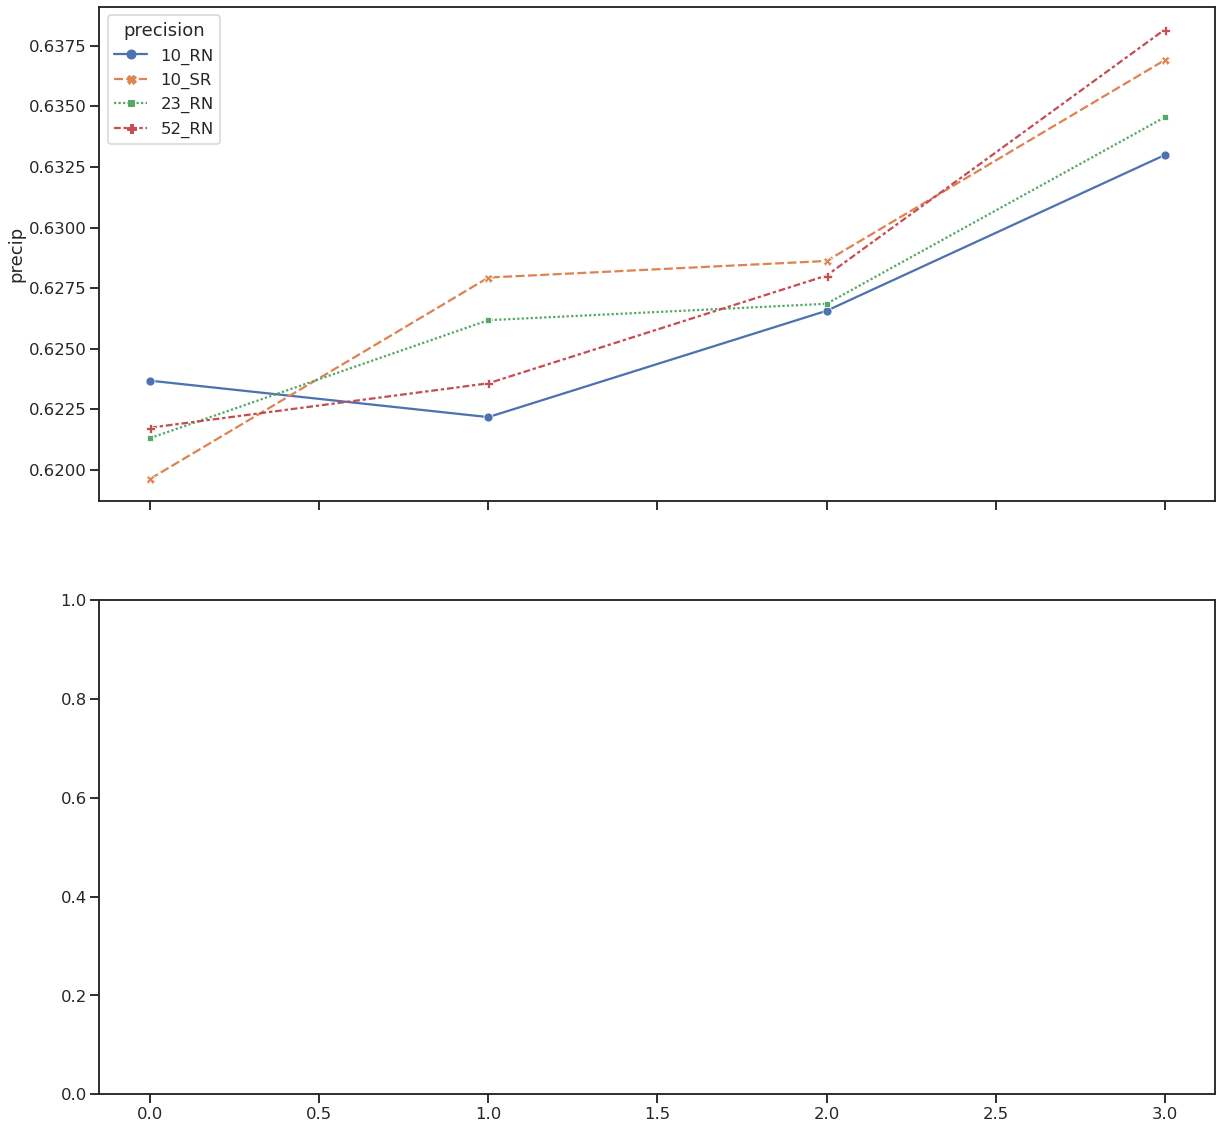

In [121]:
plot_timeseries(df)

In [39]:
f8 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_52_RN_m8/model_output00055.nc'
f7 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_52_RN_m7/model_output00055.nc'

In [40]:
import xarray as xr
df7 =  xr.open_dataset(f7)
df8 =  xr.open_dataset(f8)

In [41]:

def calc(ds):

    #Get precipitations
    LSP = ds.large_scale_precipitation * (6*60*60) / 1000 #mm / 6h
    CVP = ds.convective_precipitation  * (6*60*60) / 1000 #mm / 6h              

         
        
    #Average
    LSP_av = LSP.mean(("longitude", "latitude"))
    CVP_av = CVP.mean(("longitude", "latitude"))
    precipitation = LSP_av + CVP_av 
    
    return precipitation

In [42]:
p8 = calc(df8)
p7 = calc(df7)

In [43]:
p8.mean()

<xarray.DataArray ()>
array(0.67245353)

In [44]:
p7.mean()

<xarray.DataArray ()>
array(0.67528153)

In [36]:
p7

<xarray.DataArray (forecast_period: 365)>
array([0.        , 0.64396705, 0.62377284, 0.71139291, 0.64117134,
       0.73438115, 0.57861534, 0.7295237 , 0.68768495, 0.60493947,
       0.61987204, 0.51783714, 0.5806324 , 0.57715273, 0.56141977,
       0.58467261, 0.56598452, 0.63452142, 0.73590867, 0.58373477,
       0.55012382, 0.60536432, 0.66676394, 0.52714262, 0.59628101,
       0.60512604, 0.63233581, 0.66076122, 0.52743212, 0.54454419,
       0.54058376, 0.51372199, 0.65814206, 0.64164389, 0.67467506,
       0.66125535, 0.65326216, 0.55222329, 0.56942741, 0.59509293,
       0.61809084, 0.5779053 , 0.66032054, 0.57362398, 0.6321388 ,
       0.72236477, 0.67242137, 0.58758309, 0.57075698, 0.60319951,
       0.61565115, 0.68654005, 0.53999618, 0.56022174, 0.60615625,
       0.65139858, 0.65656072, 0.67732201, 0.6490188 , 0.65171094,
       0.64127055, 0.63658664, 0.57971088, 0.54092306, 0.49089288,
       0.5692779 , 0.60235768, 0.62752879, 0.61719511, 0.55417973,
       0.58678593, 0.57784675, 0.59519304, 0.66257035, 0.51616556,
       0.53203524, 0.60297804, 0.61806901, 0.641384  , 0.65873915,
       0.66662598, 0.64454531, 0.54581427, 0.64275346, 0.58747973,
       0.54288176, 0.61628644, 0.61390831, 0.64316206, 0.65819598,
       0.62438623, 0.59248299, 0.56930039, 0.64582036, 0.61786097,
       0.61192328, 0.7181671 , 0.63632786, 0.53844413, 0.61018218,
...
       0.60683592, 0.59144881, 0.60127321, 0.61707313, 0.65197514,
       0.58849876, 0.6022097 , 0.61934531, 0.58369495, 0.70080053,
       0.59109044, 0.68990357, 0.64307872, 0.63549916, 0.58741836,
       0.56780657, 0.57905469, 0.6494221 , 0.61615135, 0.63203601,
       0.64501623, 0.5972054 , 0.58761324, 0.57999374, 0.58673755,
       0.58476691, 0.55619975, 0.59746833, 0.6230533 , 0.66514147,
       0.6442311 , 0.60682761, 0.58794567, 0.61863725, 0.5933272 ,
       0.59630929, 0.56144436, 0.58497324, 0.55258712, 0.58899185,
       0.56877321, 0.59479885, 0.5971371 , 0.50867214, 0.58576573,
       0.6238802 , 0.60750067, 0.65624742, 0.66163804, 0.65944261,
       0.64246326, 0.6521552 , 0.69901084, 0.60878877, 0.54134586,
       0.52046876, 0.64484236, 0.56871846, 0.61457555, 0.65370427,
       0.68296033, 0.52901534, 0.60858389, 0.68431479, 0.63831839,
       0.63961441, 0.62706226, 0.58356469, 0.57090363, 0.52626501,
       0.59282083, 0.63487244, 0.61610481, 0.64832813, 0.60767344,
       0.57527974, 0.60806259, 0.60414397, 0.58014347, 0.64090597,
       0.61779412, 0.57768803, 0.55371359, 0.61835508, 0.60053535,
       0.54700855, 0.6375971 , 0.56610458, 0.60964691, 0.63283377,
       0.60267405, 0.63587159, 0.55489011, 0.6420235 , 0.64258316,
       0.62710045, 0.61487594, 0.64150112, 0.59858899, 0.53562105])
Coordinates:
  * forecast_period  (forecast_period) timedelta64[ns] 0 days ... 364 days

# What if we just load one member?

In [75]:
df6  = pd.read_pickle('m5_example.pkl')


def process_single_example(df):
    
    df_averaged = df.groupby([df.index//time_period, 'label','level','precision', 'title'],as_index=False).mean()
    
    
    df52 = df_averaged.query('precision == "52_RN"').copy()
    dfrest = df_averaged.query('precision != "52_RN"').copy()

    df52['merge_column'] = df52['X'].astype(int) #Create a column to merge on.  
    dfrest['merge_column'] = dfrest['X'].astype(int) #Create a column to merge on.  



    #merge
    df_join = pd.merge(dfrest,df52,how='left', on='merge_column', suffixes=(None, '_52RN'))
    df_join['MBE'] = df_join['temperature'] - df_join['temperature_52RN']
    df_join['MAE'] = abs(df_join['temperature'] - df_join['temperature_52RN'])
    
    display(df_join.groupby(by='precision').mean())


In [76]:
df5 = pd.read_pickle('m5_example.pkl')
process_single_example(df5)

,temperature,X,merge_column,temperature_52RN,X_52RN,MBE,MAE
precision,,,,,,,
10_RN,290.899987,18249.5,18249.5,290.944332,18249.5,-0.044345,0.051589
10_SR,290.958596,18249.5,18249.5,290.944332,18249.5,0.014264,0.033596
23_RN,290.940689,18249.5,18249.5,290.944332,18249.5,-0.003643,0.027036


In [77]:
df6 = pd.read_pickle('m6_example.pkl')
process_single_example(df6)

,temperature,X,merge_column,temperature_52RN,X_52RN,MBE,MAE
precision,,,,,,,
10_RN,290.901412,18249.5,18249.5,290.94025,18249.5,-0.038839,0.044088
10_SR,290.963709,18249.5,18249.5,290.94025,18249.5,0.023459,0.034519
23_RN,290.941315,18249.5,18249.5,290.94025,18249.5,0.001065,0.024896


In [78]:
df7 = pd.read_pickle('m7_example.pkl')
process_single_example(df7)

,temperature,X,merge_column,temperature_52RN,X_52RN,MBE,MAE
precision,,,,,,,
10_RN,290.901086,18249.5,18249.5,290.93587,18249.5,-0.034784,0.043336
10_SR,290.966847,18249.5,18249.5,290.93587,18249.5,0.030978,0.040696
23_RN,290.939314,18249.5,18249.5,290.93587,18249.5,0.003444,0.023897


In [82]:
process_single_example(df.query('ensemble == "m6"'))

,temperature,X,merge_column,temperature_52RN,X_52RN,MBE,MAE
precision,,,,,,,
10_RN,290.901412,18249.5,18249.5,290.94025,18249.5,-0.038839,0.044088
10_SR,290.963709,18249.5,18249.5,290.94025,18249.5,0.023459,0.034519
23_RN,290.941315,18249.5,18249.5,290.94025,18249.5,0.001065,0.024896
